# Syntactic Analysis of XLM-R-fused NMT Systems

This notebook contains code to trace the transfer of the syntactic knowledge from the XLM-R to the Transformer based NMT Systems.

In [1]:
import collections
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
plt.rc('font', family='Lohit Devanagari')
plt.rcParams.update({'font.size': 22})

/home/atanwar/miniconda3/envs/nlu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atanwar/miniconda3/envs/nlu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atanwar/miniconda3/envs/nlu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atanwar/miniconda3/envs/nlu/lib/python3.7/s

### Loading the data

Load the pickle files containing UD dataset along with the attention maps. See the README for extracting attention maps on your own data.

In [2]:
def load_pickle(fname):
  with open(fname, "rb") as f:
    return pickle.load(f, encoding="utf-8")  # add, encoding="latin1") if using python3 and downloaded data

root_path = '/home/atanwar/Documents/Edinburgh_Acad/Thesis/code/transfer-learning-language-family-bert/syntactic_analysis/attention-analysis/data/processed/hi/saved_attn_pkl/'

dev_path = root_path + 'xlmr.large-fused-S2-encoder/self/val_attn.pkl'
train_path = root_path + 'xlmr.large-fused-S2-encoder/self/train_attn.pkl'

#dev_path = root_path + 'baseline/self/val_attn.pkl'
#train_path = root_path + 'baseline/self/train_attn.pkl'

dev_data = load_pickle(dev_path)
train_data = load_pickle(train_path)
# The data consists of a list of examples (dicts)
# with the following keys/values
# {
#    "words": list of words in the sentence
#    "heads": index of each word"s syntactic head (0 for ROOT, 1 for the first 
#             word of the sentence, etc.)
#    "relns": the relation between each word and its head
#    "attns": [n_layers, n_heads, seq_len, seq_len] tensor of attention maps
#             from BERT
#}
print("words:", dev_data[0]["words"])
print("heads:", dev_data[0]["heads"])
print("relns:", dev_data[0]["relns"])
# Attention maps are 9x9 because [CLS] and [SEP] are added
print("attns: a tensor with shape", dev_data[0]["attns"].shape)

words: ['रामायण', 'काल', 'में', 'भगवान', 'राम', 'के', 'पुत्र', 'कुश', 'की', 'राजधानी', 'कुशावती', 'को', '483', 'ईसा', 'पूर्व', 'बुद्ध', 'ने', 'अपने', 'अंतिम', 'विश्राम', 'के', 'लिए', 'चुना', '।']
heads: [2, 23, 2, 5, 7, 5, 8, 10, 8, 11, 23, 11, 15, 15, 23, 23, 16, 20, 20, 23, 20, 20, 0, 23]
relns: ['compound', 'obl', 'case', 'compound', 'nmod', 'case', 'nmod', 'nmod', 'case', 'nmod', 'obj', 'case', 'compound', 'compound', 'obl', 'nsubj', 'case', 'nmod', 'amod', 'obl', 'case', 'case', 'root', 'punct']
attns: a tensor with shape (6, 4, 26, 26)


In [3]:
# #for dummy heatmap
# sentence_id=937
# #src_raw=dev_data[sentence_id]["words"].copy()
# #src_raw.append('</s>')
# #src_raw.insert(0,'<s>')
# src_raw=['This', 'judge', 'shall', 'be', 'chosen', 'by', 'lot', '.']
# print("words:", src_raw)
# print("heads:", dev_data[sentence_id]["heads"])
# print("relns:", dev_data[sentence_id]["relns"])
# matrix=dev_data[sentence_id]["attns"]
# for layer_id, layer in enumerate(matrix):
#     for head_id, head in enumerate(layer):
#         head[0,0]=1
#         plt.clf()
#         plt.figure(figsize=(15,15))
#         plt.imshow(head, cmap='afmhot',  interpolation="None")
#         my_xticks = src_raw
#         my_yticks = src_raw
#         ax = plt.gca()
#         ax.set_xticks(np.arange(0, len(my_xticks), 1))
#         ax.set_yticks(np.arange(0, len(my_yticks), 1))
#         ax.xaxis.tick_top()

#         plt.tick_params(axis='both', which='major', labelsize=45)
#         plt.tick_params(axis='both', which='minor', labelsize=2)

#         plt.xticks(np.arange(0, len(my_xticks), 1), my_xticks, rotation='vertical')
#         plt.yticks(np.arange(0, len(my_yticks), 1), my_yticks)
#         file_name = root_path + '/heatmaps/' + 'layer_'+ str(layer_id) + '_head_' + str(head_id)
#         plt.tight_layout()     
#         plt.savefig(file_name)
#         if(layer_id==1 and head_id==3):
#          print(head)
#         #break
#     #break    

In [4]:
# Find the most common relations in our data
reln_counts = collections.Counter()
for example in dev_data:
  for reln in example["relns"]:
    reln_counts[reln] += 1
print(reln_counts.most_common(10))

[('case', 6792), ('compound', 3673), ('nmod', 3508), ('obl', 3029), ('punct', 2372), ('nsubj', 2080), ('obj', 1725), ('root', 1659), ('amod', 1501), ('mark', 1400)]


### Evaluating individual attention heads

In [5]:
# Code for evaluating individual attention maps and baselines

def evaluate_predictor(prediction_fn):
  """Compute accuracies for each relation for the given predictor."""
  n_correct, n_incorrect = collections.Counter(), collections.Counter()
  for dev_id, example in enumerate(dev_data):
    words = example["words"]
    predictions = prediction_fn(example)
    for i, (p, y, r) in enumerate(zip(predictions, example["heads"],
                                      example["relns"])):
      is_correct = (p == y)
      if r == "poss" and p < len(words):
        # Special case for poss (see discussion in Section 4.2)
        if i < len(words) and words[i + 1] == "'s" or words[i + 1] == "s'":
          is_correct = (predictions[i + 1] == y)
      if is_correct:
        n_correct[r] += 1
        n_correct["all"] += 1
        #if(r=='nsubj'):
        #    print("Correct example:", words, "for relation:", r, 'id:', dev_id,"word:",words[i], "head:", p)
      else:
        n_incorrect[r] += 1
        n_incorrect["all"] += 1
  return {k: n_correct[k] / float(n_correct[k] + n_incorrect[k])
          for k in n_incorrect.keys()}

def attn_head_predictor(layer, head, mode="normal"):
  """Assign each word the most-attended-to other word as its head."""
  def predict(example):
    attn = np.array(example["attns"][layer][head])
    if mode == "transpose":
      attn = attn.T
    elif mode == "both":
      attn += attn.T
    else:
      assert mode == "normal"
    # ignore attention to self and [CLS]/[SEP] tokens
    attn[range(attn.shape[0]), range(attn.shape[0])] = 0
    attn = attn[1:-1, 1:-1]
    return np.argmax(attn, axis=-1) + 1  # +1 because ROOT is at index 0
  return predict

def offset_predictor(offset):
  """Simple baseline: assign each word the word a fixed offset from
  it (e.g., the word to its right) as its head."""
  def predict(example):
    return [max(0, min(i + offset + 1, len(example["words"])))
            for i in range(len(example["words"]))]
  return predict

def get_scores(mode="normal"):
  """Get the accuracies of every attention head."""
  scores = collections.defaultdict(dict)
  for layer in range(6):
    for head in range(4):
      scores[layer][head] = evaluate_predictor(
          attn_head_predictor(layer, head, mode))
  return scores

In [6]:

# attn_head_scores[direction][layer][head][dep_relation] = accuracy
attn_head_scores = {
    "dep->head": get_scores("normal"),
    "head<-dep": get_scores("transpose")
}
# baseline_scores[offset][dep_relation] = accuracy
baseline_scores = {
    i: evaluate_predictor(offset_predictor(i)) for i in range(-3, 3)
}

In [7]:
#Getting explicit scores for qualitative example:
#evaluate_predictor(
#          attn_head_predictor(layer=1, head=1, mode="normal"))

In [8]:
def get_all_scores(reln):
  """Get all attention head scores for a particular relation."""
  all_scores = []
  for key, layer_head_scores in attn_head_scores.items():
    for layer, head_scores in layer_head_scores.items():
      for head, scores in head_scores.items():
        all_scores.append((scores[reln], layer, head, key))
  return sorted(all_scores, reverse=True)

In [9]:

# Compare the best attention head to baselines across the most common relations.
for row, (reln, _) in enumerate([("all", 0)] + reln_counts.most_common()):
  if reln == "root" or reln == "punct":
    continue
  if reln_counts[reln] < 100 and reln != "all":
    break

  uas, layer, head, direction = sorted(
      s for s in get_all_scores(reln))[-1]
  baseline_uas, baseline_offset = max(
      (scores[reln], i) for i, scores in baseline_scores.items())
  print("{:8s} | {:5d} | attn: {:.1f} | offset={:2d}: {:.1f} | {:}-{:} {:}".format(
      reln[:8], reln_counts[reln], 100 * uas, baseline_offset, 100 * baseline_uas,
      layer, head, direction))
     

all      |     0 | attn: 20.9 | offset=-1: 25.0 | 2-1 dep->head
case     |  6792 | attn: 70.5 | offset=-1: 83.8 | 3-2 dep->head
compound |  3673 | attn: 52.6 | offset= 1: 77.3 | 1-1 head<-dep
nmod     |  3508 | attn: 29.5 | offset= 2: 48.1 | 2-0 dep->head
obl      |  3029 | attn: 8.6 | offset= 2: 12.9 | 3-0 head<-dep
nsubj    |  2080 | attn: 22.6 | offset= 2: 19.6 | 1-1 head<-dep
obj      |  1725 | attn: 25.4 | offset= 1: 25.4 | 2-1 head<-dep
amod     |  1501 | attn: 57.3 | offset= 1: 73.0 | 1-1 head<-dep
mark     |  1400 | attn: 31.3 | offset=-1: 35.5 | 3-2 dep->head
aux      |  1127 | attn: 38.0 | offset=-1: 99.0 | 3-1 head<-dep
aux:pass |  1095 | attn: 30.2 | offset=-2: 52.1 | 3-1 head<-dep
conj     |   794 | attn: 12.2 | offset=-2: 24.2 | 3-0 dep->head
cc       |   693 | attn: 24.5 | offset= 1: 28.6 | 3-1 dep->head
det      |   662 | attn: 66.6 | offset= 1: 83.2 | 1-1 head<-dep
nummod   |   568 | attn: 49.5 | offset= 1: 76.2 | 1-1 head<-dep
dep      |   523 | attn: 49.7 | offset=-1

### Qualitative examples of attention (Figure 5)

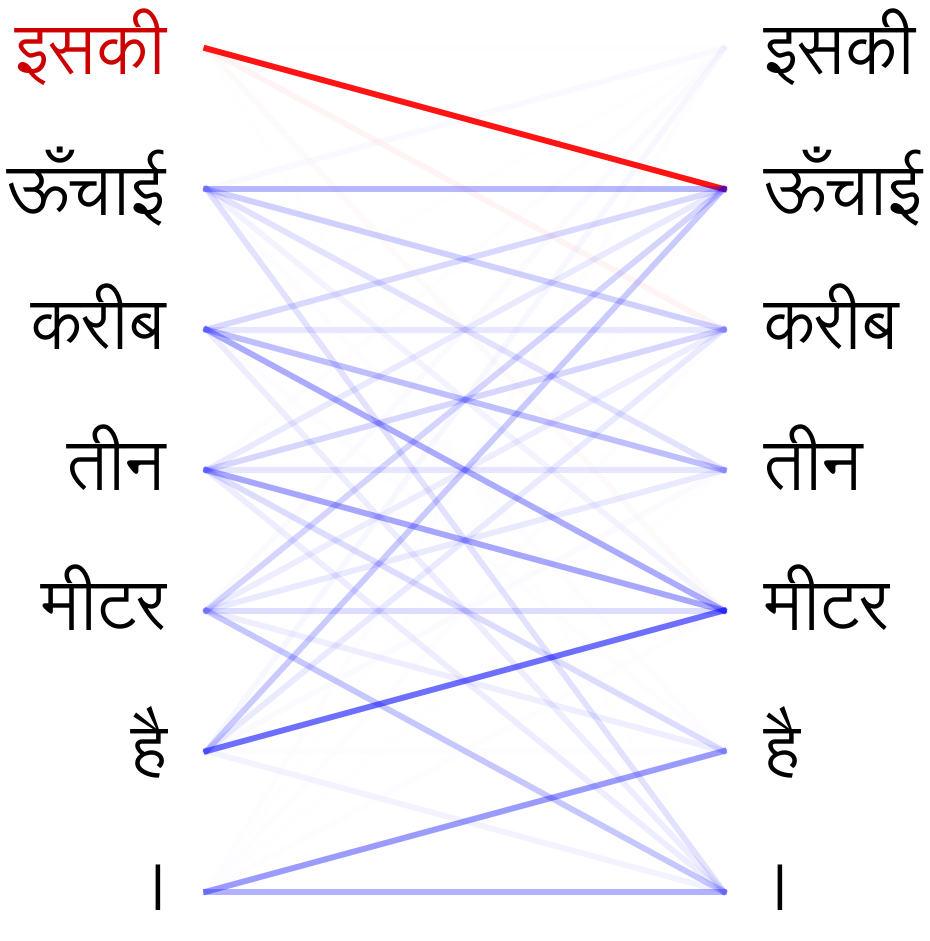

'\nplot_attn("Noun premodifiers", [dev_data[13], dev_data[1671]], 7, 10, \n          ["language", "law", "fight", "time", "executive"], color_from=False)\nplot_attn("Posessive", [dev_data[111], dev_data[244]], 6, 5,\n          ["his", "\'s", "its"])\nplot_attn("Passive auxiliary", [dev_data[192], dev_data[680]], 3, 9,\n         ["been", "was"])\nplot_attn("Object of prep", [dev_data[i] for i in [975, 979]], 8, 5,\n          ["in", "with", "to", "of", "at"], hide_sep=True)\n#plot_attn(["PRT", dev_data[152], dev_data[1692]], 5, 6,\n#          ["out", "around"])\n'

In [10]:
def plot_attn(title, examples, layer, head, color_words,
              color_from=True, width=3, example_sep=3, 
              word_height=1, pad=0.1, hide_sep=False):
  """Plot BERT's attention for a particular head/example."""
  plt.figure(figsize=(15, 15))
  for i, example in enumerate(examples):
    yoffset = 0
    if i == 0:
      #yoffset += (len(examples[0]["words"]) -
      #            len(examples[1]["words"])) * word_height / 2
      yoffset += (len(examples[0]["words"])) * word_height / 2
    xoffset = i * width * example_sep
    attn = example["attns"][layer][head]
    if hide_sep:
      attn = np.array(attn)
      attn[:, 0] = 0
      attn[:, -1] = 0
      attn /= attn.sum(axis=-1, keepdims=True)

    #words = ["[CLS]"] + example["words"] + ["[SEP]"]
    words = ["<s>"] + example["words"] + ["</s>"]
    n_words = len(words)
    for position, word in enumerate(words):
      if(position==0 or position==len(words)-1):
          continue  
      for x, from_word in [(xoffset, True), (xoffset + width, False)]:
        color = "k"
        if from_word == color_from and word in color_words:
          color = "#cc0000"
        plt.text(x, yoffset - (position * word_height), word,
                 ha="right" if from_word else "left", va="center",
                 color=color)

    for i in range(n_words):
      if(i==0 or i==n_words-1):
          continue
      #print('i:',i)       
      for j in range(n_words):
        if(j==0 or j==n_words-1):
          continue 
        color = "b"
        if words[i if color_from else j] in color_words:
          color = "r"
        plt.plot([xoffset + pad, xoffset + width - pad],
                 [yoffset - word_height * i, yoffset - word_height * j],
                 color=color, linewidth=6, alpha=attn[i, j])
  plt.axis("off")
  #plt.title(title)
  file_name = root_path + '/heatmaps/qualitative'
  plt.tight_layout()     
  plt.savefig(file_name)  
  plt.show()

plt.rc('font', family='Lohit Devanagari')
plt.rcParams.update({'font.size': 70})
# Examples from Figure 5 of the paper.
plot_attn("Relation: Nominal Modifier", [dev_data[24]], 2, 0, ["कुशीनगर", "इसकी"],
         width=30, word_height=20, example_sep=4,pad=2, hide_sep=False)
#plot_attn("Relation: Nominal Subject", [dev_data[1101]], 2, 0, ["फूकन", "इसकी"],
#         width=30, word_height=20, example_sep=4,pad=2, hide_sep=False)
'''
plot_attn("Noun premodifiers", [dev_data[13], dev_data[1671]], 7, 10, 
          ["language", "law", "fight", "time", "executive"], color_from=False)
plot_attn("Posessive", [dev_data[111], dev_data[244]], 6, 5,
          ["his", "'s", "its"])
plot_attn("Passive auxiliary", [dev_data[192], dev_data[680]], 3, 9,
         ["been", "was"])
plot_attn("Object of prep", [dev_data[i] for i in [975, 979]], 8, 5,
          ["in", "with", "to", "of", "at"], hide_sep=True)
#plot_attn(["PRT", dev_data[152], dev_data[1692]], 5, 6,
#          ["out", "around"])
'''

### Probing classifiers (Section 5)

In [11]:
class WordEmbeddings(object):
  """Class for loading/using pretrained GloVe embeddings"""
    
  def __init__(self):
    self.pretrained_embeddings = load_pickle("./data/glove/embeddings.pkl")
    self.vocab = load_pickle("./data/glove/vocab.pkl")

  def tokid(self, w):
    return self.vocab.get(w.lower(), 0)

In [12]:
N_DISTANCE_FEATURES = 8
def make_distance_features(seq_len):
  """Constructs distance features for a sentence."""
  # how much ahead/behind the other word is
  distances = np.zeros((seq_len, seq_len))
  for i in range(seq_len):
    for j in range(seq_len):
      if i < j:
        distances[i, j] = (j - i) / float(seq_len)
  feature_matrices = [distances, distances.T]

  # indicator features on if other word is up to 2 words ahead/behind
  for k in range(3):
    for direction in ([1] if k == 0 else [-1, 1]):
      feature_matrices.append(np.eye(seq_len, k=k*direction))
  features = np.stack(feature_matrices)

  # additional indicator feature for ROOT
  features = np.concatenate(
      [np.zeros([N_DISTANCE_FEATURES - 1, seq_len, 1]), 
       features], -1)
  root = np.zeros((1, seq_len, seq_len + 1))
  root[:, :, 0] = 1

  return np.concatenate([features, root], 0)

In [13]:
def attn_linear_combo():
  return Probe()


def attn_and_words():
  return Probe(use_words=True)


def words_and_distances():
  return Probe(use_distance_features=True, use_attns=False,
               use_words=True, hidden_layer=True)


class Probe(object):
  """The probing classifier used in Section 5."""

  def __init__(self, use_distance_features=False, use_words=False,
               use_attns=True, include_transpose=True, hidden_layer=False):
    #self._embeddings = WordEmbeddings()

    # We use a simple model with batch size 1
    self._attns = tf.placeholder(
        shape=[6, 4, None, None], dtype=tf.float32)
    self._labels = tf.placeholder(
        shape=[None], dtype=tf.int32)
    self._features = tf.placeholder(
        shape=[N_DISTANCE_FEATURES, None, None], dtype=tf.float32)
    self._words = tf.placeholder(shape=[None], dtype=tf.int32)

    if use_attns:
      seq_len = tf.shape(self._attns)[-1]
      if include_transpose:
        # Include both directions of attention
        attn_maps = tf.concat(
            [self._attns,
             tf.transpose(self._attns, [0, 1, 3, 2])], 0)
        attn_maps = tf.reshape(attn_maps, [48, seq_len, seq_len])
      else:
        attn_maps = tf.reshape(self._attns, [24, seq_len, seq_len])
      # Use attention to start/end tokens to get score for ROOT
      root_features = (
          (tf.get_variable("ROOT_start", shape=[]) * attn_maps[:, 1:-1, 0]) +
          (tf.get_variable("ROOT_end", shape=[]) * attn_maps[:, 1:-1, -1])
      )
      attn_maps = tf.concat([tf.expand_dims(root_features, -1),
                             attn_maps[:, 1:-1, 1:-1]], -1)
    else:
      # Dummy attention map for models not using attention inputs
      n_words = tf.shape(self._words)[0]
      attn_maps = tf.zeros((1, n_words, n_words + 1))

    if use_distance_features:
      attn_maps = tf.concat([attn_maps, self._features], 0)

    if use_words:
      word_embedding_matrix = tf.get_variable(
          "word_embedding_matrix",
          initializer=self._embeddings.pretrained_embeddings,
          trainable=False)
      word_embeddings = tf.nn.embedding_lookup(word_embedding_matrix, self._words)
      n_words = tf.shape(self._words)[0]
      tiled_vertical = tf.tile(tf.expand_dims(word_embeddings, 0),
                               [n_words, 1, 1])
      tiled_horizontal = tf.tile(tf.expand_dims(word_embeddings, 1),
                                 [1, n_words, 1])
      word_reprs = tf.concat([tiled_horizontal, tiled_vertical], -1)
      word_reprs = tf.concat([word_reprs, tf.zeros((n_words, 1, 200))], 1) # dummy for ROOT
      if not use_attns:
        attn_maps = tf.concat([
            attn_maps, tf.transpose(word_reprs, [2, 0, 1])], 0)

    attn_maps = tf.transpose(attn_maps, [1, 2, 0])
    if use_words and use_attns:
      # attention-and-words probe
      weights = tf.layers.dense(word_reprs, attn_maps.shape[-1])
      self._logits = tf.reduce_sum(weights * attn_maps, axis=-1)
    else:
      if hidden_layer:
        # 1-hidden-layer MLP for words-and-distances baseline
        attn_maps = tf.layers.dense(attn_maps, 256,
                                    activation=tf.nn.tanh)
        self._logits = tf.squeeze(tf.layers.dense(attn_maps, 1), -1)
      else:
        # linear combination of attention heads
        attn_map_weights = tf.get_variable("attn_map_weights",
                                           shape=[attn_maps.shape[-1]])
        self._logits = tf.reduce_sum(attn_map_weights * attn_maps, axis=-1)

    loss = tf.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=self._logits, labels=self._labels))
    opt = tf.train.AdamOptimizer(learning_rate=0.002)
    self._train_op = opt.minimize(loss)

  def _create_feed_dict(self, example):
    return {
        self._attns: example["attns"],
        self._labels: example["heads"],
        self._features: make_distance_features(len(example["words"])),
        #self._words: [self._embeddings.tokid(w) for w in example["words"]]
    }

  def train(self, sess, example):
    return sess.run(self._train_op, feed_dict=self._create_feed_dict(example))

  def test(self, sess, example):
    return sess.run(self._logits, feed_dict=self._create_feed_dict(example))


def run_training(probe, train_data):
  """Trains and evaluates the given attention probe."""
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(5):
      print(40 * "=")
      print("EPOCH", (epoch + 1))
      print(40 * "=")
      print("Training...")
      for i, example in enumerate(train_data):
        if i % 2000 == 0:
          print("{:}/{:}".format(i, len(train_data)))
        probe.train(sess, example)
      
      eval_rel_dict=dict()
      print("Evaluating...")
      correct, total = 0, 0
      for i, example in enumerate(dev_data):
        if i % 1000 == 0:
          print("{:}/{:}".format(i, len(dev_data)))
        logits = probe.test(sess, example)
        for i, (head, prediction, reln) in enumerate(
            zip(example["heads"], logits.argmax(-1), example["relns"])):
          # it is standard to ignore punct for Stanford Dependency evaluation
          if reln != "punct":
            if head == prediction:
              correct += 1
              if(reln in eval_rel_dict):
                  eval_rel_dict[reln] += 1
              else: eval_rel_dict[reln] = 1   
            total += 1
      print("UAS: {:.1f}".format(100 * correct / total))
      print(eval_rel_dict)
      for row, (reln, _) in enumerate(reln_counts.most_common()):
          if reln == "root" or reln == "punct" or reln not in eval_rel_dict:
            continue
          #if reln_counts[reln] < 100 and reln != "all":
          #  break

          #uas, layer, head, direction = sorted(
          #    s for s in get_all_scores(reln))[-1]
          #baseline_uas, baseline_offset = max(
          #    (scores[reln], i) for i, scores in baseline_scores.items())
          uas = eval_rel_dict[reln]/reln_counts[reln]
          print("{:8s} | {:5d} | {:.1f} ".format(
              reln[:8], reln_counts[reln], 100 * uas))  

## UAS by Attention-based Probing Classifier

In [14]:
tf.reset_default_graph()
run_training(attn_linear_combo(), train_data)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
EPOCH 1
Training...
0/13304
2000/13304
4000/13304
6000/13304
8000/13304
10000/13304
12000/13304
Evaluating...
0/1659
1000/1659
UAS: 30.4
{'compound': 1387, 'case': 3934, 'nmod': 820, 'amod': 752, 'nsubj': 360, 'mark': 350, 'cop': 264, 'det': 339, 'aux': 362, 'advmod': 111, 'aux:pass': 233, 'nummod': 228, 'dep': 215, 'xcomp': 21, 'obj': 297, 'obl': 107, 'acl': 80, 'cc': 67, 'iobj': 20, 'advcl': 24, 'acl:relcl': 4, 'nsubj:pass': 4, 'conj': 9, 'root': 3}
case     |  6792 | 57.9 
compound |  3673 | 37.8 
nmod     |  3508 | 23.4 
obl      |  3029 | 3.5 
nsubj    |  2080 | 17.3 
obj      |  1725 | 17.2 
amod     |  1501 | 50.1 
mark     |  1400 | 25.0 
aux      |  1127 | 32.1 
aux:pass |  1095 | 21.3 
conj     |   794 | 1.1 
cc       |   693 | 9.7 
det      |   662 | 51.2 
nummod   |   568 | 40.1 
dep      |   523 | 41.1 
advcl    |   434 | 5.5 
cop      |   396 | 66.7 
adv